# Scikit-learn for Machine Learning

## Preparation

- Download and Install [Anaconda](https://www.continuum.io/downloads) (Python 3 version)
- Run command in a new shell: `jupyter lab`
- If you run jupyter lab in a linux server through ssh, open a new terminal
    - `ssh -L 8000:localhost:(jupyter port, default is 8888) (user)@(server address)`
    - after log in, `jupyter notebook list`, check and copy the token of your jupyter
    - open browser http://localhost:8000/, enter the token
- Create a new notebook: Left-upper area -> "+" (New launcher) -> Notebook -> Python 3

## What is Scikit-learn?

- Scikit-learn: Machine Learning in Python
    - Simple and efficient tools for data mining and data analysis
    - Accessible to everybody, and reusable in various contexts
    - Built on NumPy, SciPy, and matplotlib
    - Open source, commercially usable - BSD license
- Features:
    - Classification
    - Regression
    - Clustering
    - Dimensionality reduction
    - Model selection
    - Preprocessing

Reference: [Scikit-learn official site](http://scikit-learn.org/stable/)

## Contents

1. Machine Learning Theory
    - Loss Function
    - Training-Validation Sets
    - Cross-Validation
2. An Example for CV Training: Linear Regression
3. Over-fitting
    - Penalty Function
    - Ridge and Lasso
    - Select Penalty Coeffient
4. Tree-based Models
    - Decision Tree
    - Random Forest
    - Gradient Boosting Trees

## Scikit-learn (0) Prepare Data

In [1]:
# Load modules and set options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision = 3)
pd.set_option('precision', 3)
%matplotlib notebook
%cd ~/Stat

/Users/fangda/Stat


In [2]:
# Load price-missing data and true label data
da = pd.read_csv("Diamonds.csv", index_col = "n")
da_true = pd.read_csv("Diamonds_predict_true.csv", index_col = "n")
da.shape, da_true.shape

((53940, 10), (14232, 10))

In [3]:
# Separate X and Y
Y, X = da['price'], da.drop('price', axis = 1)
Y.shape, X.shape

((53940,), (53940, 9))

In [4]:
# Denote labeled and unlabeled row index
ir_unlab, ir_lab = da.index[Y.isnull()], da.index[~Y.isnull()]
ir_unlab.shape, ir_lab.shape

((14232,), (39708,))

## Scikit-learn (1.1): Machine Learning Theory
- Question of Machine Learning: given data $(X, Y)$, how to predict $Y$ with $X$?
    - LM: $\hat{Y} = X\beta$
    - GLM: $\hat{Y} = g^{-1}(X\beta)$
    - Generally, $\hat{Y} = f(X, \theta)$, model family $f$ and parameter $\theta$ can be complex
- Compare *statistical modeling* with *machine learning*:
    - Schools: mathematics vs. computer science
    - Focus: statistical inference vs. prediction effectiveness
    - Methods: formula-based vs. algorithm-based
    - Assumptions: strict vs. weak
    
    
Reference: [Difference between Machine Learning & Statistical Modeling, Tavish Srivastava](https://www.analyticsvidhya.com/blog/2015/07/difference-machine-learning-statistical-modeling/)

## Scikit-learn (1.2):  Machine Learning Theory: Loss Function

- Q1: Two models predict $Y$ with $\hat{Y}_1 = f_1(X, \theta_1)$, $\hat{Y}_2 = f_2(X, \theta_2)$
    - Which model is better for prediction? How to decide?
- Loss function $L(Y, \hat{Y})$: measure the error between true and predicted values, the smaller the better
    - Sum of squared errors (L2 dist): $L(Y, \hat{Y}) = \sum_{i=1}^n(y_i - \hat{y}_i)^2$
    - Sum of absolute errors (L1 dist): $L(Y, \hat{Y}) = \sum_{i=1}^n|y_i - \hat{y}_i|$
    - Misclassification errors (L0 dist): $L(Y, \hat{Y}) = \sum_{i=1}^n1(y_i \neq \hat{y}_i)$
    - Log loss for binary: $L(Y, \hat{Y}) = -\sum_{i=1}^n\left(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\right)$

In [5]:
y = np.array([0, 0, 1, 1, 1])
yhat1 = np.array([0.2, 0.3, 0.6, 0.7, 0.6])
yhat2 = np.array([0.1, 0.1, 0.9, 0.8, 0.3])

In [6]:
import sklearn.metrics as met
print(met.mean_squared_error(y, yhat1), met.mean_squared_error(y, yhat2))
print(met.mean_absolute_error(y, yhat1), met.mean_absolute_error(y, yhat2))
print(met.zero_one_loss(y, yhat1 > 0.5), met.zero_one_loss(y, yhat2 > 0.5))
print(met.log_loss(y, yhat1), met.log_loss(y, yhat2))

0.108 0.112
0.32 0.24
0.0 0.2
0.391628937345 0.348639580523


## How to get help

- From Function Help: ? + function
    - ?met.log_loss
- From Autofill with *Tab*:
    - met. + *Tab*
- From Google: Your Question (what you want to do) + scikit-learn
    - logistic regression scikit-learn
    - speed up random forest scikit-learn
- From Official Website: http://scikit-learn.org/

## Scikit-learn (1.3): Machine Learning Theory: Training-Validation Sets
- Q2: How can we know the effectiveness of prediction on data outside sample?
- Assumption: Sample are selected from population randomly
- Method: Divide our sample randomly into 2 parts: training set and validation set
    - Training Set $(X_T, Y_T)$: fitting model $\hat{\theta} = \min_{\theta\in\Theta_f}\left[L(Y_T, \hat{Y}_T) + \lambda P(\theta)\right]$
    - Validation Set $(X_V, Y_V)$: estimating prediction error $L(Y_V, \hat{Y}_V)$ from trained $\hat{\theta}$

In [7]:
# Randomly choose 5000 from index as validation set
np.random.seed(1) 
ir_v = np.random.choice(ir_lab, 10000, replace = False) 
ir_v.shape

(10000,)

In [8]:
# Use other labeled index as training set
ir_t = ir_lab.difference(ir_v) 
ir_t.shape

(29708,)

## Scikit-learn (1.4): Machine Learning Theory: Cross Validation
- Q4: How about the unused validation set?
- Cross-validation (CV): 
    1. Divide data $(X, Y)$ into $K$ parts $(X_{(1)}, Y_{(1)}), \cdots, (X_{(K)}, Y_{(K)})$
    2. Each time $i$, select $(X_{(i)}, Y_{(i)})$ as validation set, leaving other parts as training set, train a model and calculate the validation error.
    3. For $i = 1,2,\cdots K$, repeat step 2 and get $K$ models and $K$ validation errors, use mean validation errors to estimate the prediction of model
    4. For prediction of new data $X_{new}$, use the $K$ trained models to predict $\hat{Y}_{new(1)}, \cdots, \hat{Y}_{new(K)}$, and calculate the mean $\hat{Y}_{new}$ as final prediction

In [9]:
# Randomly split index equally into k = 5 folds
def Kfolds(x, k = 5, seed = 1):
    np.random.seed(seed)
    op = np.array_split(np.random.permutation(x), k)
    return(op)
ir_cv = Kfolds(ir_lab)
[i.shape for i in ir_cv]

[(7942,), (7942,), (7942,), (7941,), (7941,)]

In [10]:
# select fold 0 as validation set, leaving others as training set
ir_v = ir_cv[0]
ir_t = np.setdiff1d(np.hstack(ir_cv), ir_v)
ir_v.shape, ir_t.shape

((7942,), (31766,))

## Scikit-learn (2.1): An Example for CV Training: Linear Regression

- We will show how to compile cross-validation procedures with scikit-learn models
- In the next, we will build an extendable machine learning system step by step

In [11]:
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 100)

In [12]:
# Make sure all variable to be numeric for model
X = pd.get_dummies(X, drop_first = True)
X.head(2)

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
n,,,,,,,,,,,,,,,,,,,,,,,
1,0.23,61.5,55.0,3.95,3.98,2.43,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0.21,59.8,61.0,3.89,3.84,2.31,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [13]:
# Split X and Y with training-validation index
Xt = X.loc[ir_t]
Xv = X.loc[ir_v]
Yt = Y.loc[ir_t]
Yv = Y.loc[ir_v]
Xt.shape, Xv.shape, Yt.shape, Yv.shape

((31766, 23), (7942, 23), (31766,), (7942,))

## Scikit-learn (2.2): Single Model Training

In [14]:
# Train a linear model in scikit-learn
import sklearn.linear_model as lm
model_lm = lm.LinearRegression()
model_lm.fit(Xt, Yt)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
# Coefficients of the model
model_lm.coef_

array([ 11641.894,    -66.581,    -25.287,  -1140.763,    -12.209,
          -63.557,    551.371,    841.153,    754.372,    708.06 ,
         -177.767,   -244.366,   -447.098,   -956.701,  -1445.476,
        -2299.875,   5297.921,   3686.544,   2714.422,   4585.986,
         4267.393,   4996.976,   4937.163])

In [16]:
# Prediction on traing-validation set
Ythat = model_lm.predict(Xt)
Yvhat = model_lm.predict(Xv)
Yvhat

array([ 4134.981,  2131.571,  6300.447, ...,  1760.954,   277.292,
         934.741])

In [17]:
# Measure the training-validation loss
met.mean_squared_error(Yt.values, Ythat), met.mean_squared_error(Yv.values, Yvhat)

(1222405.0419276247, 1351848.6373490358)

## Scikit-learn (2.3): Cross-Validation Training

In [18]:
def cv_train(X, Y, ir_cv, fmodel, fscore = met.mean_squared_error, **kwargs):
    modelL, losstL, lossvL = [], [], []
    for ir_v in ir_cv:
        # Create training-validation sets
        ir_t = np.setdiff1d(np.hstack(ir_cv), ir_v)
        Xt, Xv, Yt, Yv = X.loc[ir_t], X.loc[ir_v], Y.loc[ir_t], Y.loc[ir_v]
        # Train a scikit-learn model
        model = fmodel(**kwargs)
        model.fit(Xt, Yt)
        # predict and get training-validation loss
        Ythat = model.predict(Xt)
        losst = fscore(Yt.values, Ythat)
        Yvhat = model.predict(Xv)
        lossv = fscore(Yv.values, Yvhat)
        # save model and training-validation loss
        modelL.append(model)
        losstL.append(losst)
        lossvL.append(lossv)
    op = {"modelL": modelL, 
          "loss": pd.DataFrame({"loss_train": losstL, "loss_val": lossvL})}
    return(op)

# Train linear regression CV models with MSE loss
md_lm = cv_train(X, Y, ir_cv, lm.LinearRegression)
md_lm["loss"].mean()

loss_train    1.247e+06
loss_val      1.263e+06
dtype: float64

## Scikit-learn (2.4): Cross-Validation Prediction

In [19]:
# Prepare the prediction dataset
Yp = da_true.loc[ir_unlab, "price"]
Xp = X.loc[ir_unlab]
Yp.shape, Xp.shape

((14232,), (14232, 23))

In [20]:
def cv_pred(X, Y, modelL, fscore = met.mean_squared_error):
    # Predict Yhat for each CV model
    YhatL = [model.predict(X) for model in modelL]
    # Get prediction loss for each Yhat
    lossL = [fscore(Yp.values, Yhat) for Yhat in YhatL]
    op = {"YhatL": YhatL, "lossL": lossL}
    return(op)

# Calculate prediction loss for each model on prediction data (Xp, Yp)
op_pred = cv_pred(Xp, Yp, md_lm["modelL"])
op_pred["lossL"], np.mean(op_pred["lossL"])

([1362963.7291103753,
  1361001.7484534772,
  1365815.447840391,
  1358742.7597344865,
  1363723.8601751626],
 1362449.5090627784)

In [21]:
# Calculate the loss of mean CV prediction
met.mean_squared_error(Yp.values, np.mean(op_pred["YhatL"], axis = 0))

1360221.642421219

## Scikit-learn (3.1): Over-Fitting

- To train a machine learning model, when we only $\min_{\theta\in\Theta_f}L(Y, \hat{Y})$:
- An extremely complex model may always be "better" in training set (over-fitting)
    - Fit 10,000-order polynomials on $Y$ of sample-size 10,000
    - A too complex model may not be true for population out of sample
    - A too complex model may be unstable

In [22]:
Xpoly2 = pd.concat([X, X**2], axis = 1)
Xpoly5 = pd.concat([X**(1+i) for i in range(5)], axis = 1)
X.shape, Xpoly2.shape, Xpoly5.shape

((53940, 23), (53940, 46), (53940, 115))

In [23]:
pd.concat([cv_train(i, Y, ir_cv, lm.LinearRegression)['loss'].mean()
     for i in [X, Xpoly2, Xpoly5]], axis = 1, keys = ["X", "Xpoly2", "Xpoly5"])

,X,Xpoly2,Xpoly5
loss_train,1.247e+06,1.172e+06,1.037e+06
loss_val,1.263e+06,3.141e+08,3.119e+13


## Scikit-learn (3.2): Penalty Function

- Method: find a simpler model $\hat{\theta}$ by $\min_{\theta\in\Theta_f}\left[L(Y, \hat{Y}) + \lambda P(\theta)\right]$
    - Loss function $L(Y, \hat{Y})$: control the errors of fitting
    - Penalty function $P(\theta)$: measure the complexity of model
        - Ridge (L2 dist): $P(\beta) = \sum_{i=1}^p\beta_i^2$
        - Lasso (L1 dist): $P(\beta) = \sum_{i=1}^p|\beta_i|$
        - AIC/BIC (L0 dist): $P(\beta) = \sum_{i=1}^p1(\beta_i\neq 0)$
    - Penalty coefficient $\lambda$: greater $\lambda \rightarrow$ simpler model

In [24]:
pd.concat(
    [cv_train(i, Y, ir_cv, lm.Ridge, alpha = 0.1, normalize = True)['loss'].mean()
     for i in [X, Xpoly2, Xpoly5]], axis = 1, keys = ["X", "Xpoly2", "Xpoly5"])

,X,Xpoly2,Xpoly5
loss_train,1.923e+06,1.538e+06,1.277e+06
loss_val,1.944e+06,2.267e+06,4.666e+10


In [25]:
pd.concat(
    [cv_train(i, Y, ir_cv, lm.Lasso, alpha = 0.1, normalize = True)['loss'].mean()
     for i in [X, Xpoly2, Xpoly5]], axis = 1, keys = ["X", "Xpoly2", "Xpoly5"])

/Users/fangda/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,X,Xpoly2,Xpoly5
loss_train,1.396e+06,1.411e+06,1.251e+06
loss_val,1.400e+06,1.417e+06,3.316e+11


## Scikit-learn (3.3): Select Penalty Coefficients

- How to select best penalty coeffient $\hat{\lambda}$, or more generally, best hyperparameters of model?
    - Step 1. Try different $\lambda$ on the model
        - Method 1: Build several models with different $\lambda$
        - Method 2: If exists, a stepwise model for $\lambda$ can save computation time
    - Step 2. Calculate CV validation loss, and select the $\hat{\lambda}$ minimizing it
    - Step 3. If used for variable selection, choose important variables under $\hat{\lambda}$

<IPython.core.display.Javascript object>


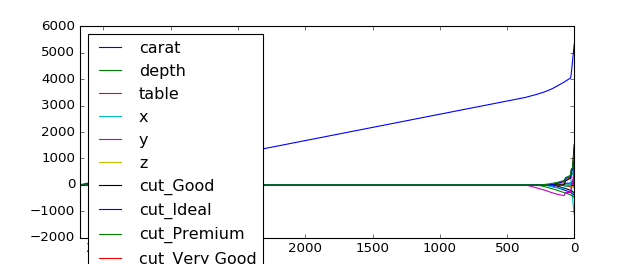

In [26]:
path_lasso = lm.lasso_path((Xt - Xt.mean())/Xt.std(), Yt)
pd.DataFrame(path_lasso[1].T, index = path_lasso[0], columns = X.columns).plot()

## Scikit-learn(4.1): Decision Tree Models
- Can we detect non-linear relationship without adding polynomial terms?
- Non-linear models: e.g. tree-based methods $\hat{Y} = Tree(X, \theta)$

In [27]:
import sklearn.tree as tree
md_tree = cv_train(X, Y, ir_cv, tree.DecisionTreeRegressor)
md_tree["loss"].mean()

loss_train        26.107
loss_val      743744.096
dtype: float64

In [28]:
# The distribution of variable used as tree split
wL_tree = [model.feature_importances_ for model in md_tree["modelL"]]
pd.DataFrame(wL_tree, columns = X.columns).mean().sort_values()

cut_Very Good    2.735e-04
cut_Good         4.159e-04
                   ...    
y                2.598e-01
carat            6.303e-01
dtype: float64

In [29]:
# Limit the depth of tree to control model complexity
cv_train(X, Y, ir_cv, tree.DecisionTreeRegressor, max_depth = 15)["loss"].mean()

loss_train    166954.960
loss_val      669473.576
dtype: float64

## Scikit-learn(4.2): Random Forest

- Build $M$ trees at the same time in each model
- To increase diversity of trees, when building each tree $\hat{\theta}_i$:
    - Randomly bootstrap $(X, Y)$ to $(X_{(i)}, Y_{(i)})$ 
    - Randomly select a subset of variables $\Theta_{i}$
- $\hat{\theta}_i  = \arg\min_{\theta_i \in \Theta_{i}}L\left(Y_{(i)}, Tree(X_{(i)}, \theta_i)\right)$
- $\hat{Y} = \frac{1}{M}\sum_{i=1}^M Tree(X, \hat{\theta}_i)$

In [30]:
import sklearn.ensemble as ensm
md_rf = cv_train(X, Y, ir_cv, ensm.RandomForestRegressor, n_estimators=10)
md_rf["loss"].mean()

loss_train     84272.896
loss_val      452528.303
dtype: float64

In [31]:
wL_rf = [model.feature_importances_ for model in md_rf["modelL"]]
pd.DataFrame(wL_rf, columns = X.columns).mean().sort_values()

cut_Very Good    3.324e-04
cut_Good         4.420e-04
                   ...    
carat            4.139e-01
y                4.714e-01
dtype: float64

In [32]:
np.mean(cv_pred(Xp, Yp, md_rf["modelL"])['lossL'])

482715.59347832418

## Scikit-learn(4.3): Gradient Boosting Trees

- Build $M$ trees stepwisely for residuals in each model
- To reduce over-fitting, when building each tree $\hat{\theta}_i$:
    - Restrict max depth of tree
    - Restrict step size $\eta < 1$
- $\hat{\theta}_i  = \arg\min_{\theta_i \in \Theta}L\left(Y - \eta\sum_{j=1}^{i-1}Tree(X, \theta_j), Tree(X, \theta_i)\right)$
- $\hat{Y} = \eta\sum_{i=1}^M Tree(X, \hat{\theta}_i)$

In [33]:
md_gbt = cv_train(X, Y, ir_cv, ensm.GradientBoostingRegressor, n_estimators = 300, learning_rate = 0.3)
md_gbt["loss"].mean()

loss_train    294816.887
loss_val      414659.551
dtype: float64

In [34]:
wL_gbt = [model.feature_importances_ for model in md_gbt["modelL"]]
pd.DataFrame(wL_gbt, columns = X.columns).mean().sort_values()

cut_Very Good    0.001
cut_Good         0.002
                 ...  
carat            0.131
y                0.180
dtype: float64

In [35]:
np.mean(cv_pred(Xp, Yp, md_gbt["modelL"])['lossL'])

444176.13327725837